In [91]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

**Before starting:** make sure that the file `merged_with_isw.csv` — dataset with historical data for model training - is located in the same directory as this notebook.

In [92]:
df_prepared_data = pd.read_csv('merged_with_isw.csv', sep=",")

## Split data Train/Test

In [93]:
X = df_prepared_data.drop(columns=['was_alarm'])
y_reg = df_prepared_data['was_alarm']
y_bin = df_prepared_data['was_alarm']

tscv = TimeSeriesSplit(n_splits=5)

## Trainig

In [94]:
df_prepared_data['hour'] = pd.to_datetime(df_prepared_data['hour_datetimeEpoch'], unit='s').dt.hour
df_prepared_data = df_prepared_data.drop(columns=['hour_datetimeEpoch'])
df_prepared_data = pd.get_dummies(df_prepared_data, columns=['region_id'], drop_first=True)

In [95]:
region_map = {
    1: "Simferopol",
    2: "Vinnytsia",
    3: "Lutsk",
    4: "Dnipro",
    5: "Donetsk",
    6: "Zhytomyr",
    7: "Uzhgorod",
    8: "Zaporozhye",
    9: "Ivano-Frankivsk",
    10: "Kyiv",
    11: "Kropyvnytskyi",
    12: "Luhansk",
    13: "Lviv",
    14: "Mykolaiv",
    15: "Odesa",
    16: "Poltava",
    17: "Rivne",
    18: "Sumy",
    19: "Ternopil",
    20: "Kharkiv",
    21: "Kherson",
    22: "Khmelnytskyi",
    23: "Cherkasy",
    24: "Chernivtsi",
    25: "Chernihiv"
}

df_prepared_data = df_prepared_data.rename(columns={
    f"region_id_{i}": region_map[i]
    for i in region_map
    if f"region_id_{i}" in df_prepared_data.columns
})


In [96]:
X = df_prepared_data.drop(columns=['was_alarm'])
y = df_prepared_data['was_alarm']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [97]:
print(type(X_train), X_train.shape)
print(type(y_train), y_train.shape)


<class 'pandas.core.frame.DataFrame'> (519370, 254)
<class 'pandas.core.series.Series'> (519370,)


In [98]:
print("NaNs in X_train:", X_train.isnull().sum().sum() if hasattr(X_train, "isnull") else np.isnan(X_train).sum())
print("NaNs in y_train:", y_train.isnull().sum() if hasattr(y_train, "isnull") else np.isnan(y_train).sum())


NaNs in X_train: 0
NaNs in y_train: 0


In [99]:
print(X_train.dtypes.value_counts())


float64    226
bool        23
object       3
int64        1
int32        1
Name: count, dtype: int64


In [100]:
print(set(y_train))  # якщо це масив


{0, 1}


In [101]:
non_numeric_cols = X_train.select_dtypes(include=['object']).columns
print(non_numeric_cols.tolist())


['date', 'day_datetime', 'hour_datetime']


In [102]:
for col in non_numeric_cols:
    print(f"\nColumn: {col}")
    print(X_train[col].unique()[:10])



Column: date
['2022-04-05' '2024-06-08' '2024-10-18' '2025-01-20' '2025-01-05'
 '2024-06-01' '2022-06-30' '2024-01-03' '2024-04-27' '2024-04-25']

Column: day_datetime
['2022-04-05' '2024-06-08' '2024-10-18' '2025-01-20' '2025-01-05'
 '2024-06-01' '2022-06-30' '2024-01-03' '2024-04-27' '2024-04-25']

Column: hour_datetime
['06:00:00' '05:00:00' '22:00:00' '17:00:00' '19:00:00' '10:00:00'
 '07:00:00' '20:00:00' '08:00:00' '14:00:00']


In [103]:
X_train = X_train.drop(columns=['day_datetime'])  # або 'date', якщо навпаки


In [104]:
X_train['hour'] = pd.to_datetime(X_train['hour_datetime'], format='%H:%M:%S').dt.hour
X_train = X_train.drop(columns=['hour_datetime'])  # вже не потрібна


In [105]:
# Переконайся, що всі колонки тепер числові:
print(X_train.dtypes.value_counts())




float64    226
bool        23
object       1
int64        1
int32        1
Name: count, dtype: int64


In [106]:
X_train.select_dtypes(include='object').columns.tolist()


['date']

In [107]:
X_test = X_test.drop(columns=['date'])


In [108]:
X_train = X_train.drop(columns=['date'])


In [109]:
X_test = X_test.drop(columns=['day_datetime', 'hour_datetime', 'date'], errors='ignore')


In [110]:
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    class_weight='balanced',
    random_state=42
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)



              precision    recall  f1-score   support

           0       0.99      1.00      1.00     94576
           1       1.00      0.98      0.99     35267

    accuracy                           1.00    129843
   macro avg       1.00      0.99      0.99    129843
weighted avg       1.00      1.00      1.00    129843



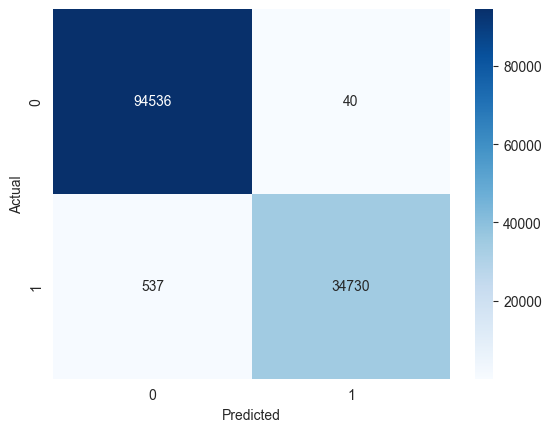

In [111]:
# Оцінка
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


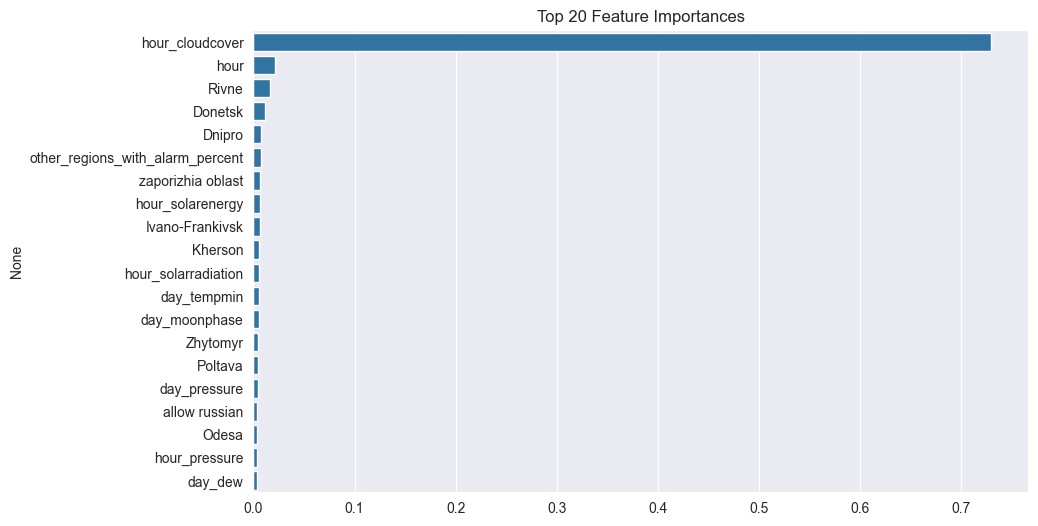

In [112]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

top_n = 20
top_features = X.columns[indices[:top_n]]
top_importances = importances[indices[:top_n]]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_features)
plt.title("Top 20 Feature Importances")
plt.show()

<Axes: xlabel='hour_cloudcover', ylabel='Count'>

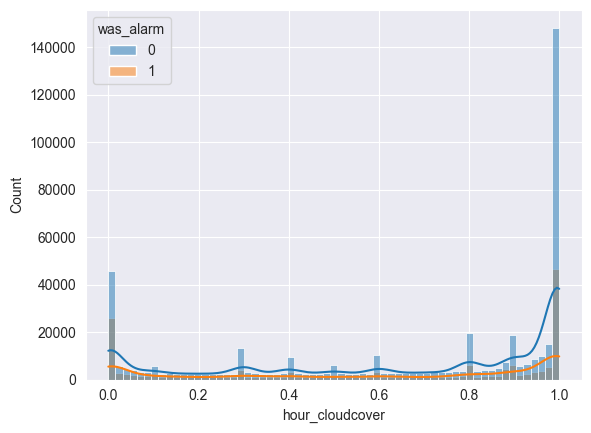

In [114]:
import seaborn as sns
sns.histplot(data=df_prepared_data, x='hour_cloudcover', hue='was_alarm', kde=True)


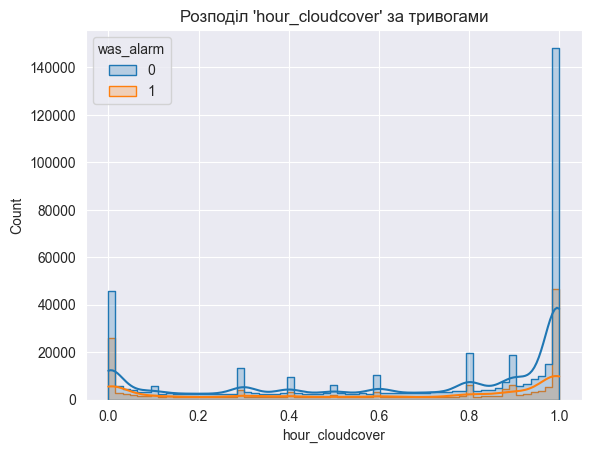

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df_prepared_data, x='hour_cloudcover', hue='was_alarm', kde=True, element='step')
plt.title("Розподіл 'hour_cloudcover' за тривогами")
plt.show()


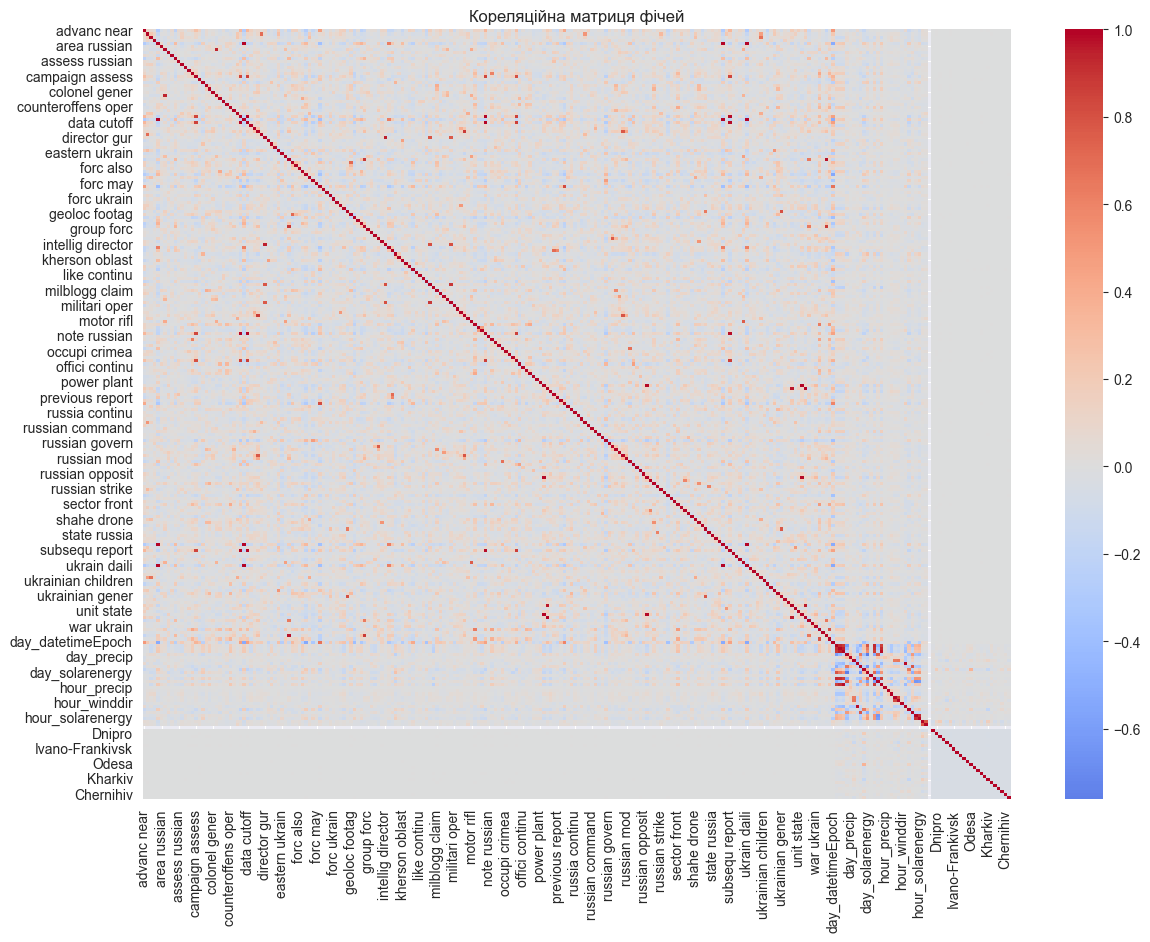

In [117]:
plt.figure(figsize=(14, 10))
corr = df_prepared_data.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title("Кореляційна матриця фічей")
plt.show()
